# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.query("is_ultra==0").shape

(2229, 5)

Пропусков нет. Датасет не сбалансирован: примерно 70/30.  Использовать только метрику оценки точночти accuracy будет не очень правильно.

In [5]:
df['gb_used'] = df['mb_used'] / 1024 # немного отмасштабируем признак
df.drop('mb_used', axis = 1, inplace=True) 

Построим взаимное распределение признаков.

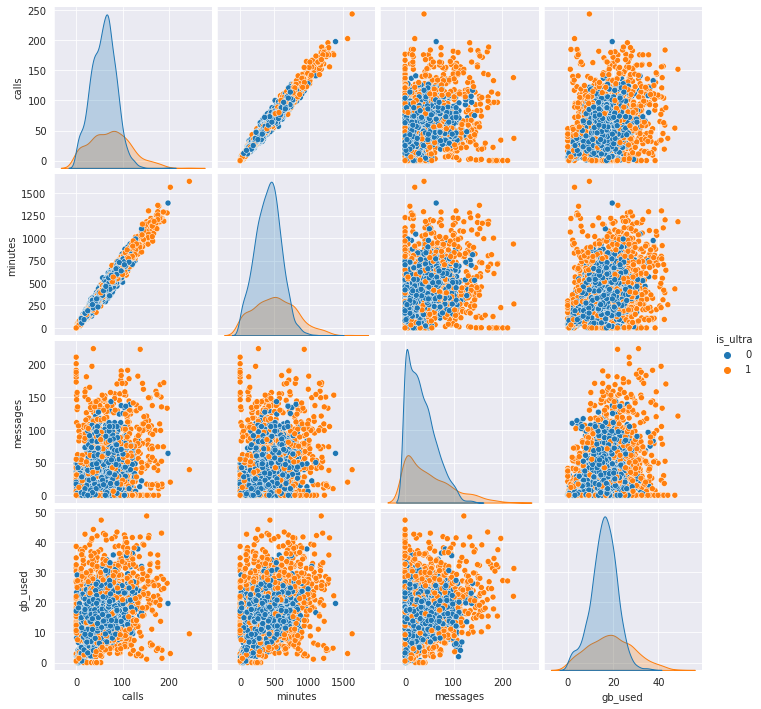

In [6]:
sns.pairplot(df, hue='is_ultra')
plt.show()

Видно явную линейную зависимость количества звонков от минут. Посчитаем точно:

In [7]:
df.corr()

,calls,minutes,messages,is_ultra,gb_used
calls,1.000000,0.982083,0.177385,0.207122,0.286442
minutes,0.982083,1.000000,0.173110,0.206955,0.280967
messages,0.177385,0.173110,1.000000,0.203830,0.195721
is_ultra,0.207122,0.206955,0.203830,1.000000,0.198568
gb_used,0.286442,0.280967,0.195721,0.198568,1.000000


Попробовал удалить один из признаков (https://habr.com/ru/company/nix/blog/425253/), модели обучаются хуже.

In [8]:
#X = df.drop('calls', axis=1, inplace=True)

Пробовал удалять оба признака, результат - модели обучаются чуточку хуже.

## Разбейте данные на выборки

Выделим фичи и целевой признак:

In [9]:
X = df.drop('is_ultra', axis=1)
y = df['is_ultra']

Разделим наши данные на тренировочную, валидационную и тестовую в соотношении 70/20/10. Валидационную выборку возьмем больше, чтобы получить более точную оценку сравнения моделей.

In [10]:
RS = 12345  # переменная со значением random_state

In [11]:
(X_train, X_tmp, y_train, y_tmp) = train_test_split(X, y, test_size=3/10, random_state=RS)
(X_vld, X_test, y_vld, y_test) = train_test_split(X_tmp, y_tmp, test_size=1/3, random_state=RS)

In [12]:
X_train.shape[0] # размер тренировочный выборки

2249

<b> Итог: нам предостоит проверить модели бинарной классификации.

Да, я подумал над этим, но так как задание и обсуждения в Слаке требовали разбивки на три части, решил сделать три. Суть понял, если ты не против, оставлю как есть.

## Исследуйте модели

Для поиска наилучших гиперпараметров для алгоритмов деревьев попробую использовать метод GridSearchCV
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


### LogisticRegression

In [13]:
def fit_gsm(model, params, x, y):
    clf = GridSearchCV(model, params)
    clf.fit(x, y)
    return clf

In [14]:
lrc = LogisticRegression(random_state=12345) 
params = { 'tol' : [1e-2, 1e-3, 1e-4, 1e-5],
          'max_iter': range(100, 1000, 50)}

clf = fit_gsm(lrc, params, X_train, y_train)

Для вывода информации по результатам обучения модели, будем использовать такую функцию

In [15]:
def get_resume(clf, x, y, gs=True): #gs - GridSearchCV
    print('Результаты обучения модели:')
    if gs:
        print('лучшие параметры:', clf.best_params_)
    vld_pred = clf.predict(x)
    acc = accuracy_score(y, vld_pred)
    print('точность:', acc)
    print('матрица ошибок:\n', confusion_matrix(y, vld_pred))
    print('f1-мера:', f1_score(y, vld_pred))

Источники:
Матрица ошибок https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
Т.к. датасет не взвешенный по классам, глянем на еще одну меру точности модели:
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [16]:
get_resume(clf, X_vld, y_vld)

Результаты обучения модели:
лучшие параметры: {'max_iter': 100, 'tol': 0.01}
точность: 0.7620528771384136
матрица ошибок:
 [[442   6]
 [147  48]]
f1-мера: 0.3855421686746988


Модель сделала очень много ошибок  типа FP (ложно отрицательные), ошибок 1 рода, то есть для значений is_ultra == 0 ошибочно предсказывала значение 1.  
Вывод: модель получилась низкого качества, но уже с точностью выше чем нужно в задании.

### DecisionTreeClassifier

In [17]:
params = {'max_depth': range(1, 30)}
dtc = DecisionTreeClassifier(random_state=RS)
clf = GridSearchCV(dtc, params)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 30)})

In [18]:
get_resume(clf, X_vld, y_vld, gs=True)

Результаты обучения модели:
лучшие параметры: {'max_depth': 3}
точность: 0.7884914463452566
матрица ошибок:
 [[422  26]
 [110  85]]
f1-мера: 0.5555555555555556


Качество модели получилось чуть лучше, но незначительно, также много ошибок 1 рода. Двигаемся дальше. Самые большие надежды на случайный лес :)

### RandomForestClassifier

Попробую по твоему совету использовать RandomizedSearchCV. Спойлер: модель действительно обучилась на порядки быстрее, но дала чуть меньшую точность.

In [19]:
params = {'n_estimators': range(2, 30) , 'max_depth': range(1, 20), 'max_features': ['auto', 'sqrt', 'log2']}
rfc = RandomForestClassifier(random_state=RS)
clf = RandomizedSearchCV(rfc, params)
clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=12345),
                   param_distributions={'max_depth': range(1, 20),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': range(2, 30)})

In [20]:
get_resume(clf, X_vld, y_vld, gs=True)

Результаты обучения модели:
лучшие параметры: {'n_estimators': 24, 'max_features': 'auto', 'max_depth': 7}
точность: 0.7993779160186625
матрица ошибок:
 [[418  30]
 [ 99  96]]
f1-мера: 0.5981308411214953


Из за большого количества вычислений, модель обучается долго. Как и предполагалось, классификатор "случайный лес" дал наилучшие результаты, хотя, к сожалению, опередил "дерево" незначительно. Предполагал, что он даст значительно более точные прогнозы. 

Предпологаю, что ошибки возникают на стыке и пересечении фичей у тарифов. А ошибки первого рода тут говорят о том, что клиентов на тарифе Смарт, которые пересходовали пакет и по фичам потребления приближались к клиентам "Ультра" алгоритм определял как 1, а вот наоборот - клиентов которые мало потребляли пакет Ultra было меньше  и ошибок этого типа, соот-но, тоже меньше.

## Проверьте модель на тестовой выборке

In [21]:
get_resume(clf, X_test, y_test, gs=True)

Результаты обучения модели:
лучшие параметры: {'n_estimators': 24, 'max_features': 'auto', 'max_depth': 7}
точность: 0.8229813664596274
матрица ошибок:
 [[210  13]
 [ 44  55]]
f1-мера: 0.6586826347305389


<b>Вывод: опробовали 3 модели для прогнозирования тарифа для оператора сотовой связи изучив при этом несколько показателей точности предсказания моделей. Все модели наиболее склонны к ошибке 1 рода.
    
Ожидаемо, алгоритм "случайный лес" дал наилучшие результаты. Проверка на тестовой выборке подтвердили результаты, полученные на валидационной. Приз достается алгориму классификации "случайный лес"! :)

А стоило ли тогда разбивать на валид. и тест. выборку в начале?

## (бонус) Проверьте модели на адекватность

In [23]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_test, y_test)
get_resume(dummy_clf, X_test, y_test, gs=False)

Результаты обучения модели:
точность: 0.6925465838509317
матрица ошибок:
 [[223   0]
 [ 99   0]]
f1-мера: 0.0


Как я писал ранее, несбалсированность классов 70/30, "глупый" классификатор как раз и показал примерно такую точность учитывая параметр strategy="most_frequent". Сравнивая полученную точность, можно сделать вывод, что полученный ранее классификаторы - адекватные.